<a href="https://colab.research.google.com/github/Asaduzzamanhipu/Machine-Learning/blob/main/17_data_aumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will build a CNN to classify flower images. We will also see how our model overfits and how overfitting can be addressed using data augmentation. Data augmentation is a process of generating new training samples from current training dataset using transformations such as zoom, rotations, change in contrast etc

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import PIL
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

We will download flowers dataset from google website and store it locally. In below call it downloads the zip file (.tgz) in cache_dir which is . meaning the current folder

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
drive_path = '/content/drive/MyDrive/flower_dataset'



In [8]:
import os
import urllib.request
import tarfile

# Dataset URL
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Create folder if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Path to save the downloaded file
data_dir = os.path.join(drive_path, 'flower_photos.tgz')

# Download
urllib.request.urlretrieve(dataset_url, download_path)

# Extract
with tarfile.open(download_path, 'r:gz') as tar:
    tar.extractall(path=drive_path)

print("✅ Downloaded and extracted to Google Drive!")


✅ Downloaded and extracted to Google Drive!


In [9]:
data_dir

'/content/drive/MyDrive/flower_dataset/flower_photos.tgz'

In [14]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/flower_dataset/flower_photos')
data_dir

PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos')

In [15]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/14810868100_87eb739f26_m.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/1446090416_f0cad5fde4.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/15319767030_e6c5602a77_m.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/15032112248_30c5284e54_n.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/7211616670_2d49ecb3a5_m.jpg')]

In [16]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [17]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/14810868100_87eb739f26_m.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/1446090416_f0cad5fde4.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/15319767030_e6c5602a77_m.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/15032112248_30c5284e54_n.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/7211616670_2d49ecb3a5_m.jpg')]

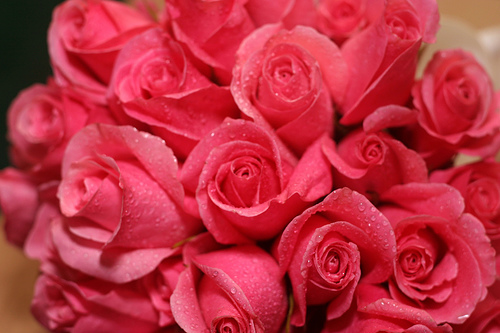

In [20]:
PIL.Image.open(str(roses[1]))

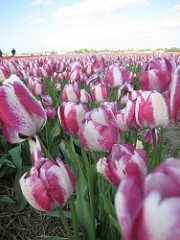

In [21]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## Read flowers images from disk into numpy array using opencv

In [22]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [23]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [24]:
flowers_images_dict['roses'][:5]

[PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/14810868100_87eb739f26_m.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/1446090416_f0cad5fde4.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/15319767030_e6c5602a77_m.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/15032112248_30c5284e54_n.jpg'),
 PosixPath('/content/drive/MyDrive/flower_dataset/flower_photos/roses/7211616670_2d49ecb3a5_m.jpg')]

In [25]:
str(flowers_images_dict['roses'][0])

'/content/drive/MyDrive/flower_dataset/flower_photos/roses/14810868100_87eb739f26_m.jpg'

In [26]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [27]:
img.shape

(240, 178, 3)

In [28]:
cv2.resize(img,(180,180)).shape

(180, 180, 3)

In [29]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [30]:
X = np.array(X)
y = np.array(y)

## Train test split

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Preprocessing: Scaling

In [32]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

Build a traditional ANN model

In [34]:
num_classes = 5

model = keras.models.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.3035 - loss: 1.6561
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5714 - loss: 1.0541
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6714 - loss: 0.8551
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7728 - loss: 0.6270
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8496 - loss: 0.4304
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9207 - loss: 0.2557
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9668 - loss: 0.1160
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9827 - loss: 0.0703
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9905 - loss: 0.0429
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9908 - loss: 0.0381
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9944 - loss: 0.0214
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy:

In [35]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6124 - loss: 3.4733


[3.4166853427886963, 0.6339869499206543]

## Here we see that while train accuracy is very high (99%), the test accuracy is significantly low (66.99%) indicating overfitting. Let's make some predictions before we use data augmentation to address overfitting

In [36]:
predictions = model.predict(X_test_scaled)
predictions

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


array([[ 13.517184 ,   8.244879 , -30.896158 , -28.575096 ,   3.289307 ],
       [ 27.425865 , -20.689484 , -51.463352 , -24.4882   ,  11.986001 ],
       [ -2.7881513,  -9.7073555,   4.102152 ,  -2.4411182,  -5.225949 ],
       ...,
       [-16.046383 , -15.183592 , -20.536535 ,  19.284332 ,  -4.422651 ],
       [  8.175179 ,   5.5822473,   3.1127036, -18.403465 ,  -7.8844395],
       [-13.837127 , -11.559449 , -16.192047 ,  14.388237 ,  -6.96803  ]],
      dtype=float32)

In [37]:
score = tf.nn.softmax(predictions[0])

In [38]:
np.argmax(score)

np.int64(0)

In [39]:
y_test[0]

np.int64(1)

## Improve Test Accuracy Using Data Augmentation

In [43]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Original Image

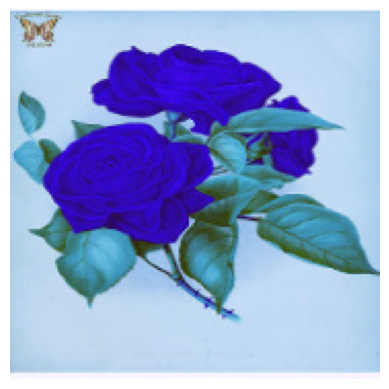

In [44]:
plt.axis('off')
plt.imshow(X[0])

## Newly generated training sample using data augmentation



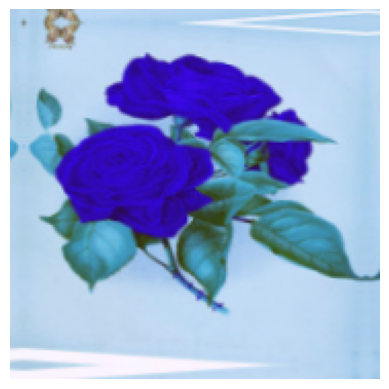

In [45]:
plt.axis('off')
plt.imshow(data_augmentation(X)[0].numpy().astype("uint8"))

## Train the model using data augmentation and a drop out layer


In [47]:
num_classes = 5

model = keras.Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.2937 - loss: 1.5951
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5758 - loss: 1.0612
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6124 - loss: 0.9773
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6456 - loss: 0.8905
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6806 - loss: 0.8202
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6876 - loss: 0.7916
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7219 - loss: 0.7248
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7326 - loss: 0.6842
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7366 - loss: 0.6940
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7492 - loss: 0.6427
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7639 - loss: 0.5901
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy:

In [48]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7244 - loss: 0.9756


[0.9994597434997559, 0.7298474907875061]

**So we see that after augmentation the test accuracy is increasd to almost 73%**